In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import trimesh

scene = trimesh.Scene()

In [2]:
import my_code.diffusion_training.data_loading as data_loading

dataset = data_loading.get_val_dataset(
    'FAUST_orig', 'train', 200
    )[1]

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Loading base dataset: 100%|███████████████████████████████████████████████████████████████████████████| 80/80 [00:15<00:00,  5.27it/s]


In [4]:
import importlib
importlib.reload(diffusion_network)

NameError: name 'diffusion_network' is not defined

In [47]:
class RandomSignDataset(torch.utils.data.Dataset):
    def __init__(self, verts, faces, evecs, n_random_signs):
        self.verts = verts
        self.faces = faces
        self.evecs = evecs  
        self.n_random_signs = n_random_signs
        
        # only signs for indices will be flipped
        self.random_indices = np.random.randint(0, evecs.shape[1], n_random_signs)
        

    def __len__(self):
        return self.n_random_signs

    def __getitem__(self, idx):
        sign_sequence = torch.randint(0, 2, (feature_dim,)).float()
        sign_sequence[sign_sequence == 0] = -1
        
        evecs_flipped = self.evecs.clone()
        evecs_flipped[:, self.random_indices] *= sign_sequence
        
        return evecs_flipped
    
    
train_shape = dataset[0]['second']

sign_dataset = RandomSignDataset(
    train_shape['verts'],
    train_shape['faces'],
    train_shape['evecs'][:, :feature_dim],
    n_random_signs=4
)

In [18]:
# get number of model parameters
n_params = sum(p.numel() for p in net.parameters())
n_params

505

In [338]:
class MLPEstimator(torch.nn.Module):
    def __init__(self, n_verts, in_channels, out_channels):
        super().__init__()
        self.n_verts = n_verts
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.layers = torch.nn.Sequential(
            # torch.nn.Linear(n_verts * in_channels, n_verts * out_channels),
            # torch.nn.ReLU(),
            torch.nn.Linear(n_verts * in_channels, 1000),
            torch.nn.Linear(1000, n_verts * out_channels),
            torch.nn.ReLU(),
        )
        
    def forward(self, verts, faces, feats):
        x = feats
        x = x.reshape(x.shape[0], self.n_verts * self.in_channels)
        x = self.layers(x)
        x = x.reshape(x.shape[0], self.n_verts, self.out_channels)
        return x
    
    
feature_dim = 64

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net_mlp = MLPEstimator(
        n_verts=6890,
        in_channels=feature_dim,
        out_channels=feature_dim,
    ).to(device)

# print n of parameters
print('n parameters', sum(p.numel() for p in net_mlp.parameters()))

opt = torch.optim.Adam(net_mlp.parameters(), lr=1e-3)

n parameters 882361960


In [3]:
def predict_sign_change(net, verts, faces, evecs_flip, evecs_cond):
    
    # normalize the evecs
    evecs_flip = torch.nn.functional.normalize(evecs_flip, p=2, dim=1)
    
    if evecs_cond is not None:
        evecs_cond = torch.nn.functional.normalize(evecs_cond, p=2, dim=1)
        evecs_input = torch.cat([evecs_flip, evecs_cond], dim=-1)
    else:
        evecs_input = evecs_flip
        
    
    # evecs_input = torch.nn.functional.normalize(evecs_input, p=2, dim=1)
    
    # process the flipped evecs
    support_vector_flip = net(
        verts=verts,
        faces=faces,
        feats=evecs_input,
    ) # [1 x 6890 x 1]
    
    # apply sigmoid
    # support_vector_flip_sigmoid = torch.sigmoid(support_vector_flip)
    # support_vector_flip_sigmoid = torch.nn.functional.log_softmax(support_vector_flip, dim=1)
    
    # normalize the support vector
    support_vector_norm = torch.nn.functional.normalize(support_vector_flip, p=2, dim=1)
    
    # multiply the support vector by the flipped evecs [1 x 6890 x 4].T @ [1 x 6890 x 4]
    # product_with_support = support_vector_flip.transpose(1, 2) @ evecs_flip
    product_with_support = support_vector_norm.transpose(1, 2) @ evecs_flip
    
    
    # print('evecs_input', evecs_input)
    # print('support_vector_flip', support_vector_flip)
    # print('product_with_support', product_with_support)
    
    # print(product_with_support.shape)
    
    if product_with_support.shape[1] == product_with_support.shape[2]:
        # product_with_support = torch.diag_embed(product_with_support)
        # take only diagonal elements
        product_with_support = torch.diagonal(product_with_support, dim1=1, dim2=2)
        
    # print(product_with_support.shape)
    
    # get the sign of the support vector
    # sign_flip_predicted = torch.sign(product_with_support)
    
    # print(product_with_support)
    # sign_flip_predicted = torch.tanh(product_with_support)
    sign_flip_predicted = product_with_support
    
    # print(sign_flip_predicted.shape)
    
    return sign_flip_predicted

In [4]:
import networks.diffusion_network as diffusion_network

condition_dim = 0

device = 'cuda' if torch.cuda.is_available() else 'cpu'

feature_dim = 32
net = diffusion_network.DiffusionNet(
    in_channels=feature_dim,
    # out_channels=feature_dim,
    out_channels=1,
    cache_dir=f'data_with_smpl_corr/FAUST_original/{200}',
    input_type='wks',
    # n_block=1,
    # hidden_channels=8,
    ).to(device)

opt = torch.optim.Adam(net.parameters(), lr=1e-3)


In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd


# train_shape = dataset[0]['second']

# verts = train_shape['verts'].unsqueeze(0).to(device)
# faces = train_shape['faces'].unsqueeze(0).to(device)

# evecs_orig = train_shape['evecs'][:, 1:1+feature_dim].unsqueeze(0).to(device)

# evecs_cond = train_shape['evecs'][:,
#     1+feature_dim:1+feature_dim+condition_dim
#     ].unsqueeze(0).to(device).abs()


# loss_fn = torch.nn.BCEWithLogitsLoss()
loss_fn = torch.nn.MSELoss()
losses = torch.tensor([])
iterator = tqdm(range(10001))


possible_shapes = [
    dataset[0]['second'],
    dataset[5]['second']
    ]
for i in iterator:

    ##############################################
    # Select a shape
    ##############################################
    curr_idx = np.random.randint(0, len(possible_shapes))
    
    train_shape = possible_shapes[curr_idx]

    verts = train_shape['verts'].unsqueeze(0).to(device)
    faces = train_shape['faces'].unsqueeze(0).to(device)

    evecs_orig = train_shape['evecs'][:, 1:1+feature_dim].unsqueeze(0).to(device)


    ##############################################
    # Set the signs
    ##############################################

    # create a random combilation of +1 and -1, length = feature_dim
    sign_flip_gt = torch.randint(0, 2, (feature_dim,)).float().to(device)
    # sign_flip_gt = torch.zeros(feature_dim).to(device)
    sign_flip_gt[sign_flip_gt == 0] = -1
    sign_flip_gt = sign_flip_gt.float().unsqueeze(0)

    # multiply evecs [6890 x 16] by sign_flip [16]
    evecs_flip = evecs_orig * sign_flip_gt
    
    
    # print(sign_flip_gt)
    # print(evecs_orig[:, :5, :], evecs_flip[:, :5, :])
    
    
    sign_change_flipped = predict_sign_change(net, verts, faces, evecs_flip, 
                                              evecs_cond=None)
    
    
    # print(sign_change_flipped.shape)
    
    # break
    
    
    
    # sign_change_orig = predict_sign_change(net, verts, faces, evecs_orig, 
                                        #    evecs_cond=None)
    
    # print(sign_change_flipped.detach(), sign_change_orig.detach(), sign_flip_gt.detach())
    # print(sign_change_flipped * sign_change_orig, sign_flip_gt.unsqueeze(0).unsqueeze(0))

    # loss = loss_fn(
    #     sign_change_flipped * sign_change_orig, sign_flip_gt.unsqueeze(0)
    # )
    
    # loss = loss_fn(
    #     sign_change_flipped, sign_flip_gt.unsqueeze(0)
    # )
    # loss = loss_fn(sign_change_flipped[0,0], torch.tensor(0, device=device).float())
    
    # sign_change_flipped = sign_change_flipped.reshape(sign_change_flipped.shape)
    # ensure sign_change_flipped and sign_flip_gt have the same shape
    sign_change_flipped = sign_change_flipped.reshape(sign_change_flipped.shape[0], -1)
    sign_flip_gt = sign_flip_gt.reshape(sign_flip_gt.shape[0], -1)
    
    loss = loss_fn(sign_change_flipped, sign_flip_gt)

    opt.zero_grad()
    loss.backward()
    opt.step()
    
    losses = torch.cat([losses, torch.tensor([loss.item()])])
    
    # print mean of last 10 losses
    iterator.set_description(f'loss={torch.mean(losses[-10:]):.3f}')
    
    
# show as only dots without lines
# plt.plot(losses, 'o', alpha=0.5)
# plt.show()

    if i > 0 and i % 1000 == 0:
        pd.Series(losses.numpy()).rolling(10).mean().plot()
        plt.yscale('log')
        plt.show()


In [ ]:
# Seems like the network is not learning at all
# make it learn the single sign flip first


# penalize the angle (so projection is as negative as possible)
# turn on the original shape (commented out)

GT tensor([ 1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1., -1., -1., -1.,  1.,  1.,
         1.,  1.,  1., -1., -1., -1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1.,
         1., -1., -1.,  1.], device='cuda:0')
PRED tensor([[[-0.3114, -0.0127,  0.0167, -0.2131,  0.1313,  0.0752, -0.1819,
          -0.0948, -0.1916, -0.1149, -0.0353, -0.0954,  0.1238, -0.2078,
           0.0487, -0.0550, -0.2144, -0.0122, -0.1052,  0.0801,  0.0019,
           0.0185,  0.0302, -0.0985, -0.1080,  0.1471,  0.0551,  0.2482,
          -0.0170,  0.1478, -0.0764, -0.2524]]], device='cuda:0')
Signs tensor([[[-1., -1.,  1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1., -1.,
           1., -1., -1.,  1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1., -1.,  1.,
          -1., -1.,  1., -1.]]], device='cuda:0')
Incorrect signs 16 / 32


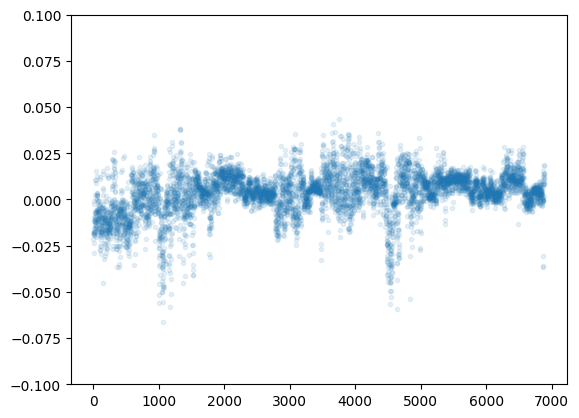

In [22]:
curr_idx = np.random.randint(0, len(possible_shapes))

# test_shape = possible_shapes[curr_idx]

test_shape = dataset[29]['second']

verts = test_shape['verts'].unsqueeze(0).to(device)
faces = test_shape['faces'].unsqueeze(0).to(device)

evecs_orig = test_shape['evecs'][:, 1:1+feature_dim].unsqueeze(0).to(device)


##############################################
# Set the signs
##############################################

sign_flip = torch.randint(0, 2, (feature_dim,)).float().to(device)
sign_flip[sign_flip == 0] = -1


# multiply evecs [6890 x 16] by sign_flip [16]
evecs_flip = evecs_orig * sign_flip

# normalize the evecs
evecs_flip = torch.nn.functional.normalize(evecs_flip, p=2, dim=1)
evecs_input = evecs_flip
    
with torch.no_grad():
    # process the flipped evecs
    support_vector_flip = net(
        verts=verts,
        faces=faces,
        feats=evecs_input,
    ) # [1 x 6890 x 1]

# normalize the support vector
support_vector_norm = torch.nn.functional.normalize(support_vector_flip, p=2, dim=1)

# multiply the support vector by the flipped evecs [1 x 6890 x 4].T @ [1 x 6890 x 4]
product_with_support = support_vector_norm.transpose(1, 2) @ evecs_flip

if product_with_support.shape[1] == product_with_support.shape[2]:
    # product_with_support = torch.diag_embed(product_with_support)
    # take only diagonal elements
    product_with_support = torch.diagonal(product_with_support, dim1=1, dim2=2)
    

sign_flip_predicted = product_with_support

sign_correct = sign_flip_predicted.sign() * sign_flip.sign()

# print('Shape idx', curr_idx)
print('GT', sign_flip)
print('PRED', sign_flip_predicted)
print('Signs', sign_correct)
print(f'Incorrect signs {torch.sum(sign_correct != 1)} / {feature_dim}')
plt.plot(support_vector_norm.squeeze().detach().cpu().numpy(), '.', alpha=0.1)
plt.ylim(-0.1, 0.1)
# plt.yscale('log')
plt.show()


In [ ]:
support_vec_plot = support_vector_flip.squeeze().detach().cpu().numpy()

# print indices of top 10 values and the values
top_indices = np.argsort(np.abs(support_vec_plot))[-30:]
print(top_indices)
print(support_vec_plot[top_indices])

scene.geometry.clear()

mesh = trimesh.Trimesh(vertices=verts.squeeze().detach().cpu().numpy(), faces=faces.squeeze().detach().cpu().numpy())
colors = np.ones((verts.shape[1], 4)) * 255
colors[top_indices] = [255, 0, 0, 255]
mesh.visual.vertex_colors = colors

scene.add_geometry(mesh)

scene.show()


# MLP estimator

In [273]:
feature_dim = 128

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net_mlp = MLPEstimator(
        n_verts=6890,
        in_channels=feature_dim,
        out_channels=feature_dim,
    ).to(device)

In [ ]:
train_shape = dataset[2]['second']

verts = train_shape['verts'].unsqueeze(0).to(device)
faces = train_shape['faces'].unsqueeze(0).to(device)

evecs_orig = train_shape['evecs'][:, 1:1+feature_dim].unsqueeze(0).to(device)

# evecs_orig is [1, 6890, 64]
# randomly rearrange the 1st dimension
evecs_orig = evecs_orig[:, torch.randperm(evecs_orig.shape[1]), :]

with torch.no_grad():

    sign_flip_gt = torch.randint(0, 2, (feature_dim,)).float().to(device)
    sign_flip_gt[sign_flip_gt == 0] = -1

    # multiply evecs [6890 x 16] by sign_flip [16]
    evecs_flip = evecs_orig * sign_flip_gt


    sign_change_flipped = predict_sign_change(net_mlp, verts, faces, evecs_flip, 
                                                evecs_cond=None)
    sign_change_orig = predict_sign_change(net_mlp, verts, faces, evecs_orig, 
                                            evecs_cond=None)
    
    sign_diff_predicted = sign_change_flipped * sign_change_orig
    error_with_gt = sign_diff_predicted - sign_flip_gt.unsqueeze(0)
    n_incorrect = (error_with_gt.abs() / 2).sum()
    print('incorrect', n_incorrect)
    
    if n_incorrect > 0:
        print('Sign change flipped', sign_change_flipped)
        print('Sign change orig', sign_change_orig)
        print('GT', sign_flip_gt)
        print('PRED', sign_diff_predicted)
        print('ERROR', error_with_gt)
        
        # plt.plot(sign_diff_predicted.squeeze().detach().cpu().numpy())
        # plt.show()

# print('flipped', sign_change_flipped, 'orig', sign_change_orig)
# print('pred', sign_change_flipped*sign_change_orig, 'gt', sign_flip_gt)
# print('incorrect', ((sign_change_flipped * sign_change_orig - sign_flip_gt.unsqueeze(0)).abs() / 2).sum())

# Try to manually find support vector

In [ ]:
feature_dim = 3

sign_flip = torch.randint(0, 2, (feature_dim,)).float().to(device)
sign_flip[sign_flip == 0] = -1

evecs_orig = train_shape['evecs'][:, 5: 5+ feature_dim].unsqueeze(0).to(device)

# multiply evecs [6890 x 16] by sign_flip [16]
evecs_flip = evecs_orig * sign_flip

print('GT', sign_flip)



with torch.no_grad():
    # vertex_combinations
    for i in range(0, evecs_orig.shape[1], 10):
    # for i in range(0, 60, 10):
        support_vector_flip = torch.zeros(1, evecs_orig.shape[1], 1).to(device)
        support_vector_flip[:, i:i+10] = 1
        
        # print('support_vector_flip', support_vector_flip)
        
        # apply sigmoid
        # support_vector_flip_sigmoid = torch.sigmoid(support_vector_flip)
        
        # print('support_vector_flip_sigmoid', support_vector_flip_sigmoid)

        # multiply the support vector by the flipped evecs
        product_with_support = support_vector_flip.transpose(1, 2) @ evecs_flip
        
        
        
        # print('product_with_support', product_with_support)

        # get the sign of the support vector, use tanh
        sign_flip_predicted = torch.tanh(product_with_support).squeeze().detach()
        # print('sign_flip_predicted', sign_flip_predicted)
        
        if torch.allclose(sign_flip_predicted, sign_flip):
            print(f'{i} OK')

In [ ]:
# pass original and flipped evecs through the network
# signs_gt = signs1 * signs2

# either use 1 support vector per eigenvector, need to use the entire dataset
# or some eigenvectors will not be aligned

In [ ]:
plt.imshow(train_shape['C_gt_xy'][0][16:48, 16:48], vmin=-1, vmax=1, cmap='bwr')
plt.show()